In [1]:
import pandas
import numpy as np
from utils import *
import mne
import matplotlib.pyplot as plt
from os import walk
from tqdm.notebook import tqdm

from sklearn.naive_bayes import GaussianNB
from itertools import combinations
from mne.time_frequency import tfr_morlet

plt.style.use('seaborn-whitegrid')

df = pandas.read_csv('./HEXACO.csv')
# Honesty-Humility	Emotionality	eXtraversion	Agreeableness	Conscientiousness	Openness to Experience
gt = df[['id','Honesty-Humility','Emotionality','eXtraversion','Agreeableness','Conscientiousness','Openness to Experience']].rename(columns={'Honesty-Humility':'h',
                                  'Emotionality':'e',
                                  'eXtraversion':'x',
                                 'Agreeableness':'a',
                             'Conscientiousness':'c',
                        'Openness to Experience':'o'}).set_index('id')
thold = 3.5
gt['lh'] = (gt[['h']] > thold) * 1
gt['le'] = (gt[['e']] > thold) * 1
gt['lx'] = (gt[['x']] > thold) * 1
gt['la'] = (gt[['a']] > thold) * 1
gt['lc'] = (gt[['c']] > thold) * 1
gt['lo'] = (gt[['o']] > thold) * 1

In [2]:
path, folders, filenames = next(walk('./data'))
# Exclude these data because of incomplete data
gt.drop([11,4,36],inplace=True)

filenames.remove('11-audio.csv')
filenames.remove('11-image.csv')

filenames.remove('36-audio.csv')
filenames.remove('36-image.csv')

In [3]:
path = './data'
columns = {'Unnamed: 1':'Fp1',
        'Unnamed: 2':'Fp2',
        'Unnamed: 3':'F3',
        'Unnamed: 4':'F4',
        'Unnamed: 5':'F7',
        'Unnamed: 6':'F8',
        'Unnamed: 7':'P7',
        'Unnamed: 8':'P8'}

EEG_audio, EEG_image = dict(), dict()
from itertools import product
categories = [1,2,3,4,5]
blocks = [1,2]
for filename in tqdm(filenames):
    participant_id, stimuli = filename.split('-')
    stimuli = stimuli.rstrip('.csv')
    data = pandas.read_csv(f'{path}/{filename}', dtype={'Marker': str}).rename(columns=columns).drop(columns='timestamps')
    # print(participant_id, stimuli)
    # experiment = dict()
    # for (category, block) in product(categories,blocks):
        # print("   ", category, block)
        # section = get_section_from_catblock(data, category=category,block=block)
        # experiment[f"{category}_{block}"] = section
    if(stimuli == 'audio'):
        EEG_audio[int(participant_id)] = data
    elif(stimuli == 'image'):
        EEG_image[int(participant_id)] = data
    else:
        raise ValueError(f"Stimuli:{stimuli} is unexpected.")

  0%|          | 0/60 [00:00<?, ?it/s]

In [21]:
# Preprocess data + feature extraction using wavelet 'morlet'
def get_data_wt(eeg_type = 'image'):
    X = None
    # y = []
    Y = None
    participant_id = []
    categories = []
    # 'DELTA' 'THETA' 'ALPHA' 'BETA' 'Gamma'
    # https://reader.elsevier.com/reader/sd/pii/S0957417410005695?token=99F7CC487CECF9C17E36713347D0F8372A289AC2C6331A2B6C4F272CD34921FD8B418EB417C0F9C3796CEA271FB4455D&originRegion=eu-west-1&originCreation=20210510142445
    filter_list = np.array([4,8,13,30,125])
    # ids = [33,2,10,12,16]
    ids = gt.index.tolist()
    for id in tqdm(ids):
        # print('\n',"="*20,id)
        if(eeg_type == 'image'):
            raw = dataframe_to_raw(EEG_image[id], sfreq=250)
        else:
            raw = dataframe_to_raw(EEG_audio[id], sfreq=250)

        raw.notch_filter([50,100],filter_length='auto', phase='zero', verbose=False) # Line power
        raw.filter(1., None, fir_design='firwin', verbose=False) # Slow drift

        events = mne.find_events(raw, stim_channel='Marker', initial_event=True, verbose=False)
        events = np.delete(events,np.argwhere(events[:,2] == 1), axis=0)
        if(events.shape[0] != 50):
            raise ValueError(f"Event missing: {events[:,2]}. len(events.shape[0])={events.shape[0]}")
        epochs = mne.Epochs(raw, events, tmin=0, tmax=5.8, baseline=(0.3,0.3), verbose=False)
        if(epochs.get_data().shape[0] != 50):
            raise ValueError(f"There might be a bad data. epochs.get_data().shape = {epochs.get_data().shape}")

        powers = tfr_morlet(epochs, freqs=filter_list, n_cycles=filter_list / 2., return_itc=False, average=False, verbose=False)
        # features = np.mean(powers.data, axis=3)
        features = powers.data
        # print(features.shape) #(50,8,5,)
        for e in range(features.shape[0]):
            row = np.expand_dims(features[e], axis=0)
            row = 10 * np.log10(row)
            if(type(X) == type(None)): X = row
            else: X = np.concatenate( [X, row ], axis=0 )
            # y.append(gt.loc[id]['label'])

            label = gt.loc[id][['lh','le','lx','la','lc','lo']].to_numpy()
            label = np.expand_dims(label, axis=0)
            if(type(Y) == type(None)): Y = label
            else: Y = np.concatenate( [Y, label ], axis=0 )
            participant_id.append(id)
        for e in events[:,2]:
            categories.append(str(e)[0])
        print(X.shape)
            # print(Y.shape)
    # y = np.array(y)
    return X,Y,np.array(participant_id),np.array(categories)

In [22]:
import warnings
warnings.filterwarnings("ignore")

channels = list(columns.values())
band_name = np.array(['DELTA','THETA','ALPHA','BETA','Gamma'])
X_head = dict()
count = 0
for channel in channels:
    for band in band_name:
        X_head[count] = (f"{channel}-{band}")
        count += 1
print(X_head)

{0: 'Fp1-DELTA', 1: 'Fp1-THETA', 2: 'Fp1-ALPHA', 3: 'Fp1-BETA', 4: 'Fp1-Gamma', 5: 'Fp2-DELTA', 6: 'Fp2-THETA', 7: 'Fp2-ALPHA', 8: 'Fp2-BETA', 9: 'Fp2-Gamma', 10: 'F3-DELTA', 11: 'F3-THETA', 12: 'F3-ALPHA', 13: 'F3-BETA', 14: 'F3-Gamma', 15: 'F4-DELTA', 16: 'F4-THETA', 17: 'F4-ALPHA', 18: 'F4-BETA', 19: 'F4-Gamma', 20: 'F7-DELTA', 21: 'F7-THETA', 22: 'F7-ALPHA', 23: 'F7-BETA', 24: 'F7-Gamma', 25: 'F8-DELTA', 26: 'F8-THETA', 27: 'F8-ALPHA', 28: 'F8-BETA', 29: 'F8-Gamma', 30: 'P7-DELTA', 31: 'P7-THETA', 32: 'P7-ALPHA', 33: 'P7-BETA', 34: 'P7-Gamma', 35: 'P8-DELTA', 36: 'P8-THETA', 37: 'P8-ALPHA', 38: 'P8-BETA', 39: 'P8-Gamma'}


In [23]:
import pickle
for eeg_type in ['image','audio']:
    X,Y,participant_id,categories = get_data_wt(eeg_type)
    data = {"Y":Y, "part_id":participant_id, "cat":categories}
    print(X.shape,Y.shape,participant_id.shape,categories.shape)
    with open(f'data_extract_raw/{eeg_type}_X.pickle', 'wb') as handle:
        pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(f'data_extract_raw/{eeg_type}_data.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/30 [00:00<?, ?it/s]

(50, 8, 5, 1451)
(100, 8, 5, 1451)
(150, 8, 5, 1451)
(200, 8, 5, 1451)
(250, 8, 5, 1451)
(300, 8, 5, 1451)
(350, 8, 5, 1451)
(400, 8, 5, 1451)
(450, 8, 5, 1451)
(500, 8, 5, 1451)
(550, 8, 5, 1451)
(600, 8, 5, 1451)
(650, 8, 5, 1451)
(700, 8, 5, 1451)
(750, 8, 5, 1451)
(800, 8, 5, 1451)
(850, 8, 5, 1451)
(900, 8, 5, 1451)
(950, 8, 5, 1451)
(1000, 8, 5, 1451)
(1050, 8, 5, 1451)
(1100, 8, 5, 1451)
(1150, 8, 5, 1451)
(1200, 8, 5, 1451)
(1250, 8, 5, 1451)
(1300, 8, 5, 1451)
(1350, 8, 5, 1451)
(1400, 8, 5, 1451)
(1450, 8, 5, 1451)
(1500, 8, 5, 1451)
(1500, 8, 5, 1451) (1500, 6) (1500,) (1500,)


  0%|          | 0/30 [00:00<?, ?it/s]

(50, 8, 5, 1451)
(100, 8, 5, 1451)
(150, 8, 5, 1451)
(200, 8, 5, 1451)
(250, 8, 5, 1451)
(300, 8, 5, 1451)
(350, 8, 5, 1451)
(400, 8, 5, 1451)
(450, 8, 5, 1451)
(500, 8, 5, 1451)
(550, 8, 5, 1451)
(600, 8, 5, 1451)
(650, 8, 5, 1451)
(700, 8, 5, 1451)
(750, 8, 5, 1451)
(800, 8, 5, 1451)
(850, 8, 5, 1451)
(900, 8, 5, 1451)
(950, 8, 5, 1451)
(1000, 8, 5, 1451)
(1050, 8, 5, 1451)
(1100, 8, 5, 1451)
(1150, 8, 5, 1451)
(1200, 8, 5, 1451)
(1250, 8, 5, 1451)
(1300, 8, 5, 1451)
(1350, 8, 5, 1451)
(1400, 8, 5, 1451)
(1450, 8, 5, 1451)
(1500, 8, 5, 1451)
(1500, 8, 5, 1451) (1500, 6) (1500,) (1500,)


## Load from pickle

In [2]:
import pickle
import numpy as np

with open(f'data_extract_raw/image_X.pickle', "rb") as handle:
    X = pickle.load(handle)
with open(f'data_extract_raw/image_data.pickle', "rb") as handle:
    data = pickle.load(handle)
Y = data['Y']
sampleRate = 250

In [3]:
from sklearn.naive_bayes import MultinomialNB as model
# from sklearn.naive_bayes import GaussianNB as model
from sklearn.model_selection import cross_val_score
times = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1,2,3,4,5]
acc_time_image = dict()
for t in times:
    print("="*20, t ,"="*20)
    for index,label in enumerate(['label_h','label_e','label_x','label_a','label_c','label_o']):
        X_copy = X.copy()[:,:,:,:int(sampleRate*t)]
        # print(X_copy.shape)
        X_copy = np.mean(X_copy, axis=3)
        win = None
        for s in range(X_copy.shape[0]):
            row = np.expand_dims(X_copy[s].reshape(-1), axis=0)
            if(type(win) == type(None)): win = row
            else: win = np.concatenate([win,row], axis=0)
        win = win*-1
        y = Y[:,index]
        # print(win.shape, y.shape)
        clf = model()
        clf.fit(win, y)
        acc = sum(clf.predict(win) == y) / len(y)
        scores = cross_val_score(clf, win, y)
        # image_predictor[label] = clf
        print(label,"| Accuracy: %0.2f Scores: %0.2f (+/- %0.2f)" % (acc,scores.mean(), scores.std() * 2))
        if(label not in acc_time_image.keys()):
            acc_time_image[label] = list()
        acc_time_image[label].append(acc)


==================== 0.1 ====================
label_h | Accuracy: 0.57 Scores: 0.43 (+/- 0.11)
label_e | Accuracy: 0.61 Scores: 0.57 (+/- 0.03)
label_x | Accuracy: 0.77 Scores: 0.76 (+/- 0.01)
label_a | Accuracy: 0.74 Scores: 0.73 (+/- 0.01)
label_c | Accuracy: 0.64 Scores: 0.61 (+/- 0.06)
label_o | Accuracy: 0.57 Scores: 0.43 (+/- 0.07)
==================== 0.2 ====================
label_h | Accuracy: 0.59 Scores: 0.42 (+/- 0.14)
label_e | Accuracy: 0.62 Scores: 0.59 (+/- 0.03)
label_x | Accuracy: 0.77 Scores: 0.77 (+/- 0.00)
label_a | Accuracy: 0.74 Scores: 0.73 (+/- 0.01)
label_c | Accuracy: 0.65 Scores: 0.62 (+/- 0.07)
label_o | Accuracy: 0.59 Scores: 0.40 (+/- 0.11)
==================== 0.3 ====================
label_h | Accuracy: 0.59 Scores: 0.40 (+/- 0.12)
label_e | Accuracy: 0.63 Scores: 0.59 (+/- 0.05)
label_x | Accuracy: 0.77 Scores: 0.77 (+/- 0.00)
label_a | Accuracy: 0.74 Scores: 0.73 (+/- 0.00)
label_c | Accuracy: 0.65 Scores: 0.62 (+/- 0.08)
label_o | Accuracy: 0.58 Scor

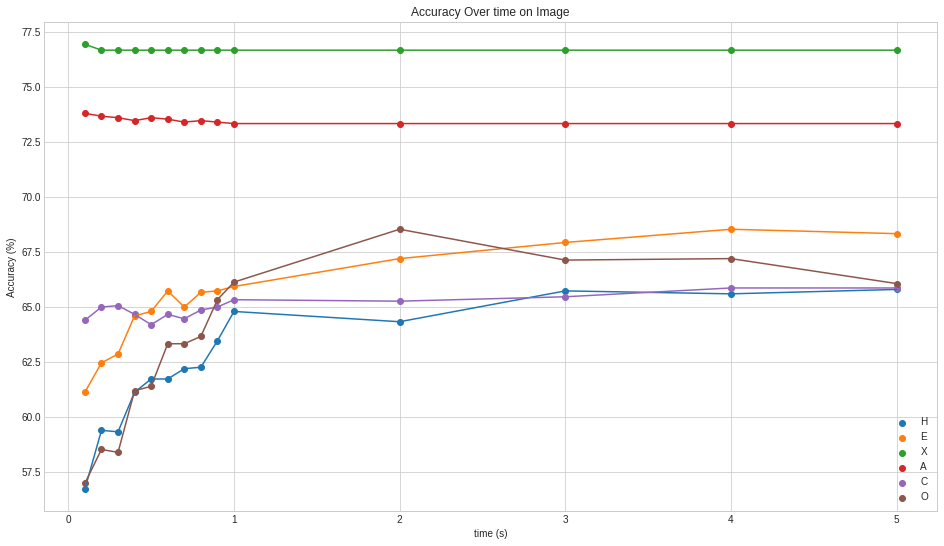

In [5]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

fig, ax = plt.subplots(figsize=(16,9))
ax.plot(times,np.array(acc_time_image['label_h'])*100)
ax.plot(times,np.array(acc_time_image['label_e'])*100)
ax.plot(times,np.array(acc_time_image['label_x'])*100)
ax.plot(times,np.array(acc_time_image['label_a'])*100)
ax.plot(times,np.array(acc_time_image['label_c'])*100)
ax.plot(times,np.array(acc_time_image['label_o'])*100)

ax.scatter(times,np.array(acc_time_image['label_h'])*100, label='H')
ax.scatter(times,np.array(acc_time_image['label_e'])*100, label='E')
ax.scatter(times,np.array(acc_time_image['label_x'])*100, label='X')
ax.scatter(times,np.array(acc_time_image['label_a'])*100, label='A')
ax.scatter(times,np.array(acc_time_image['label_c'])*100, label='C')
ax.scatter(times,np.array(acc_time_image['label_o'])*100, label='O')

ax.legend()
ax.set_title('Accuracy Over time on Image')
ax.set_xlabel('time (s)')
ax.set_ylabel('Accuracy (%)')
plt.show()

In [6]:
with open(f'data_extract_raw/audio_X.pickle', "rb") as handle:
    X = pickle.load(handle)
with open(f'data_extract_raw/audio_data.pickle', "rb") as handle:
    data = pickle.load(handle)
Y = data['Y']
acc_time_audio = dict()
for t in times:
    print("="*20, t ,"="*20)
    for index,label in enumerate(['label_h','label_e','label_x','label_a','label_c','label_o']):
        X_copy = X.copy()[:,:,:,:int(sampleRate*t)]
        # print(X_copy.shape)
        X_copy = np.mean(X_copy, axis=3)
        win = None
        for s in range(X_copy.shape[0]):
            row = np.expand_dims(X_copy[s].reshape(-1), axis=0)
            if(type(win) == type(None)): win = row
            else: win = np.concatenate([win,row], axis=0)
        win = win*-1
        y = Y[:,index]
        # print(win.shape, y.shape)
        clf = model()
        clf.fit(win, y)
        acc = sum(clf.predict(win) == y) / len(y)
        scores = cross_val_score(clf, win, y)
        # image_predictor[label] = clf
        print(label,"| Accuracy: %0.2f Scores: %0.2f (+/- %0.2f)" % (acc,scores.mean(), scores.std() * 2))
        if(label not in acc_time_audio.keys()):
            acc_time_audio[label] = list()
        acc_time_audio[label].append(acc)


==================== 0.1 ====================
label_h | Accuracy: 0.56 Scores: 0.40 (+/- 0.13)
label_e | Accuracy: 0.61 Scores: 0.57 (+/- 0.03)
label_x | Accuracy: 0.76 Scores: 0.76 (+/- 0.02)
label_a | Accuracy: 0.73 Scores: 0.72 (+/- 0.02)
label_c | Accuracy: 0.63 Scores: 0.58 (+/- 0.07)
label_o | Accuracy: 0.58 Scores: 0.49 (+/- 0.05)
==================== 0.2 ====================
label_h | Accuracy: 0.58 Scores: 0.42 (+/- 0.12)
label_e | Accuracy: 0.63 Scores: 0.57 (+/- 0.06)
label_x | Accuracy: 0.76 Scores: 0.76 (+/- 0.02)
label_a | Accuracy: 0.73 Scores: 0.71 (+/- 0.05)
label_c | Accuracy: 0.63 Scores: 0.60 (+/- 0.04)
label_o | Accuracy: 0.59 Scores: 0.50 (+/- 0.08)
==================== 0.3 ====================
label_h | Accuracy: 0.59 Scores: 0.42 (+/- 0.15)
label_e | Accuracy: 0.62 Scores: 0.57 (+/- 0.05)
label_x | Accuracy: 0.77 Scores: 0.76 (+/- 0.02)
label_a | Accuracy: 0.74 Scores: 0.71 (+/- 0.04)
label_c | Accuracy: 0.63 Scores: 0.61 (+/- 0.07)
label_o | Accuracy: 0.60 Scor

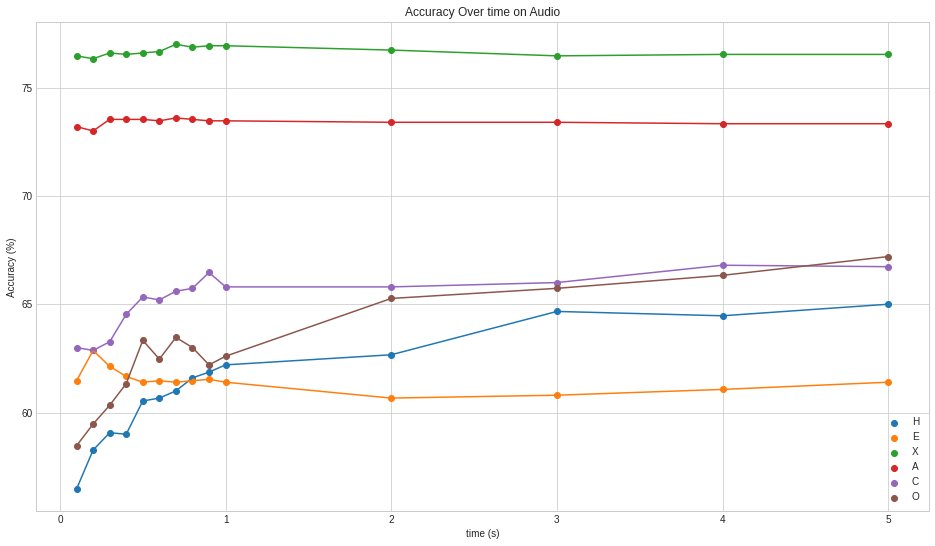

In [7]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(times,np.array(acc_time_audio['label_h'])*100)
ax.plot(times,np.array(acc_time_audio['label_e'])*100)
ax.plot(times,np.array(acc_time_audio['label_x'])*100)
ax.plot(times,np.array(acc_time_audio['label_a'])*100)
ax.plot(times,np.array(acc_time_audio['label_c'])*100)
ax.plot(times,np.array(acc_time_audio['label_o'])*100)

ax.scatter(times,np.array(acc_time_audio['label_h'])*100, label='H')
ax.scatter(times,np.array(acc_time_audio['label_e'])*100, label='E')
ax.scatter(times,np.array(acc_time_audio['label_x'])*100, label='X')
ax.scatter(times,np.array(acc_time_audio['label_a'])*100, label='A')
ax.scatter(times,np.array(acc_time_audio['label_c'])*100, label='C')
ax.scatter(times,np.array(acc_time_audio['label_o'])*100, label='O')

ax.legend()
ax.set_title('Accuracy Over time on Audio')
ax.set_xlabel('time (s)')
ax.set_ylabel('Accuracy (%)')
plt.show()

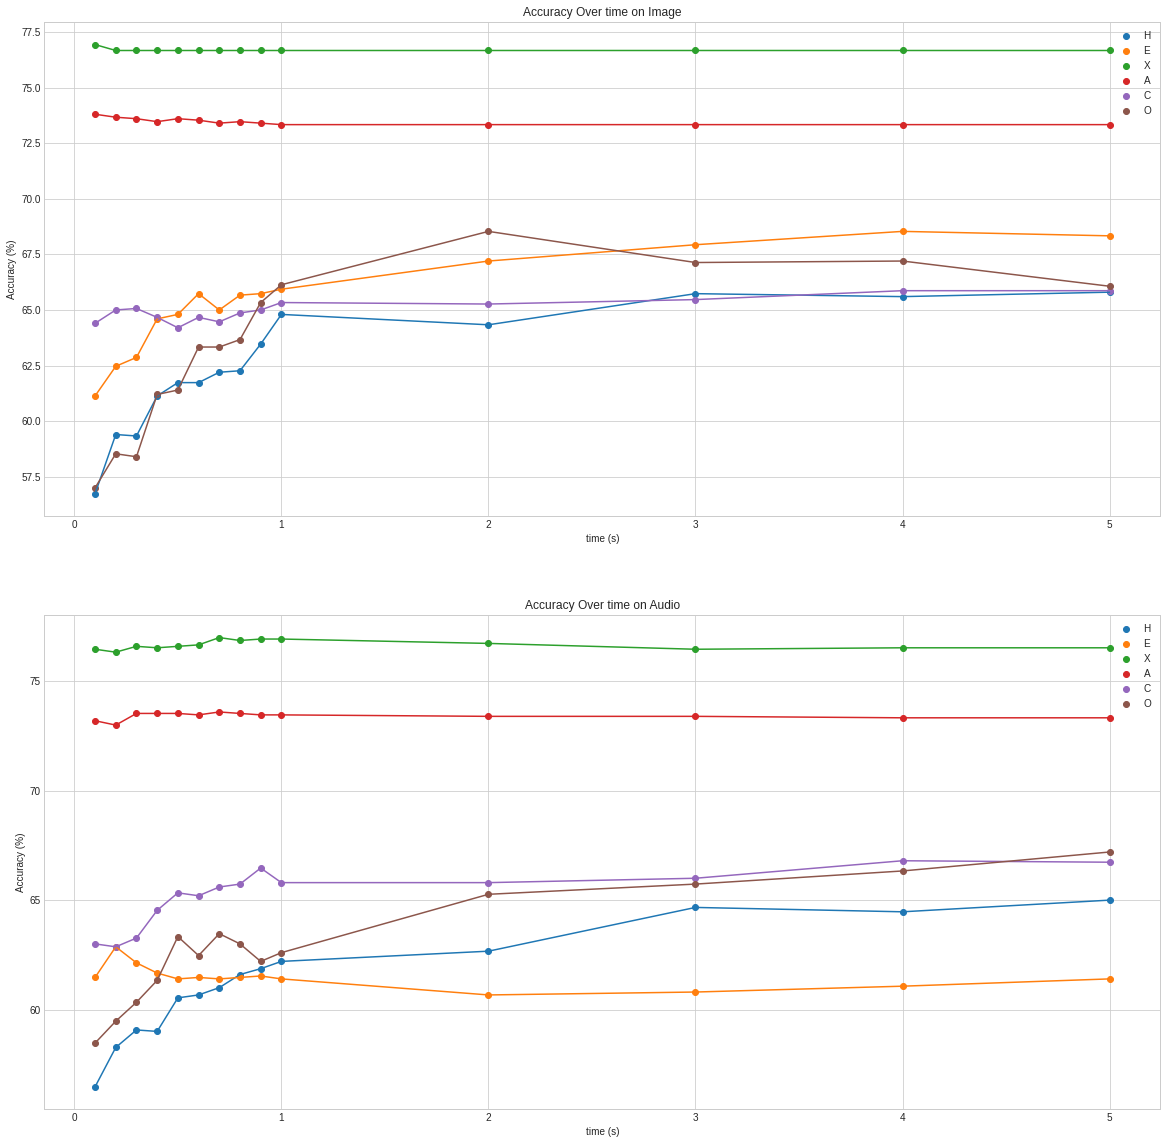

In [8]:
fig, ax = plt.subplots(2,figsize=(20,20))

ax[0].plot(times,np.array(acc_time_image['label_h'])*100)
ax[0].plot(times,np.array(acc_time_image['label_e'])*100)
ax[0].plot(times,np.array(acc_time_image['label_x'])*100)
ax[0].plot(times,np.array(acc_time_image['label_a'])*100)
ax[0].plot(times,np.array(acc_time_image['label_c'])*100)
ax[0].plot(times,np.array(acc_time_image['label_o'])*100)

ax[0].scatter(times,np.array(acc_time_image['label_h'])*100, label='H')
ax[0].scatter(times,np.array(acc_time_image['label_e'])*100, label='E')
ax[0].scatter(times,np.array(acc_time_image['label_x'])*100, label='X')
ax[0].scatter(times,np.array(acc_time_image['label_a'])*100, label='A')
ax[0].scatter(times,np.array(acc_time_image['label_c'])*100, label='C')
ax[0].scatter(times,np.array(acc_time_image['label_o'])*100, label='O')

ax[0].legend()
ax[0].set_title('Accuracy Over time on Image')
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('Accuracy (%)')


ax[1].plot(times,np.array(acc_time_audio['label_h'])*100)
ax[1].plot(times,np.array(acc_time_audio['label_e'])*100)
ax[1].plot(times,np.array(acc_time_audio['label_x'])*100)
ax[1].plot(times,np.array(acc_time_audio['label_a'])*100)
ax[1].plot(times,np.array(acc_time_audio['label_c'])*100)
ax[1].plot(times,np.array(acc_time_audio['label_o'])*100)

ax[1].scatter(times,np.array(acc_time_audio['label_h'])*100, label='H')
ax[1].scatter(times,np.array(acc_time_audio['label_e'])*100, label='E')
ax[1].scatter(times,np.array(acc_time_audio['label_x'])*100, label='X')
ax[1].scatter(times,np.array(acc_time_audio['label_a'])*100, label='A')
ax[1].scatter(times,np.array(acc_time_audio['label_c'])*100, label='C')
ax[1].scatter(times,np.array(acc_time_audio['label_o'])*100, label='O')

ax[1].legend()
ax[1].set_title('Accuracy Over time on Audio')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('Accuracy (%)')
plt.show()